# Positive Unlabeled Learning

# Case 1 - synthetic dataset

### let's generate toy dataset out of two slightly intersecting multitudes 

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs

In [1]:
from __future__ import division, print_function
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve

import matplotlib.pylab as plt
%matplotlib inline

labeled samples: 250


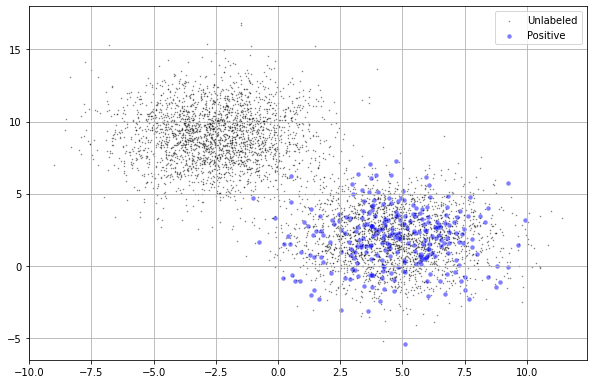

In [2]:
N = 5000
known_labels_ratio = 0.1
X, y = make_blobs(n_samples=N, centers=2, 
                  n_features=2, shuffle=True, 
                  cluster_std=2.0, random_state=42)
rp = np.random.permutation(int(N/2))
data_P = X[y==1][rp[:int(len(rp)*known_labels_ratio)]]
data_U = np.concatenate((X[y==1][rp[int(len(rp)*known_labels_ratio):]], X[y==0]), axis=0)
print("labeled samples: %d" % (data_P.shape[0]))
plt.figure(figsize=(10, 6.5))
plt.scatter(data_U[:, 0], data_U[:, 1], c='k', marker='.', linewidth=1, s=1, alpha=0.5, label='Unlabeled')
plt.scatter(data_P[:, 0], data_P[:, 1], c='b', marker='o', linewidth=0, s=20, alpha=0.5, label='Positive')
plt.grid()
plt.legend()
plt.show()

In [3]:
NP = data_P.shape[0]
NU = data_U.shape[0]

T = 1000
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
for i in range(T):
    # Bootstrap resample
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    
    # Positive set + bootstrapped unlabeled set
    data_bootstrap = np.concatenate((data_P, data_U[bootstrap_sample, :]), axis=0)
    
    # Train model
    model = DecisionTreeClassifier(max_depth=None, max_features=None, 
                                   criterion='gini', class_weight='balanced')
    model.fit(data_bootstrap, train_label)
    
    # Index for the out of the bag (oob) samples
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U[idx_oob])
    n_oob[idx_oob] += 1
    
predict_proba = f_oob[:, 1]/n_oob

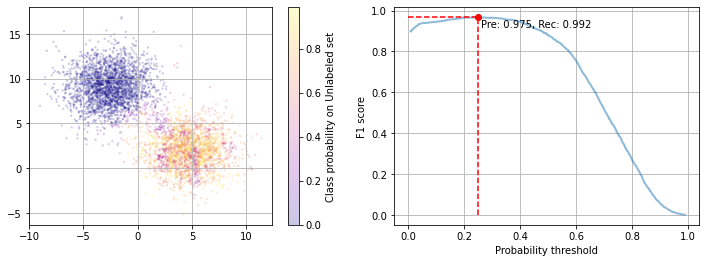

In [4]:
# Plot the class probabilities for the unlabeled samples
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1)
sp= ax1.scatter(data_U[:, 0], data_U[:, 1], c=predict_proba, 
                linewidth=0, s=5, alpha=0.22, cmap=plt.cm.plasma, label='unlabeled')  # alpha - hyperparameter
plt.grid()
plt.colorbar(sp, label='Class probability on Unlabeled set')

true_labels = np.zeros(shape=(data_U.shape[0]))
true_labels[:int(len(rp)*(1.0-known_labels_ratio))] = 1.0
precision, recall, th = precision_recall_curve(true_labels, predict_proba)
ax2 = fig.add_subplot(1, 2, 2)
f1s = precision[:-1]*recall[:-1]
ax2.plot(th, f1s, linewidth=2, alpha=0.5)
best_th = np.argmax(f1s)
ax2.plot(th[best_th], f1s[best_th], c='r', marker='o')
ax2.plot([th[best_th], th[best_th]], [0.0,f1s[best_th] ], 'r--')
ax2.plot([0.0, th[best_th]], [f1s[best_th], f1s[best_th] ], 'r--')
ax2.annotate('Pre: %0.3f, Rec: %0.3f' %(precision[best_th], recall[best_th]), 
             xy=(th[best_th]+ 0.01, f1s[best_th]-0.05))
ax2.set_ylabel('F1 score')
ax2.set_xlabel('Probability threshold')
plt.grid()

# Case 2 - selection of customers for promotion campaign

There are clients of a shop and purchases for a certain period.

Here is the dataset of items:

In [5]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

### catalog of items

In [6]:
items = pd.read_csv("items.csv")
print("Num unique items: {}\nNum unique categories: {}".format(items.shape[0], 
                                                                len(items['item_type'].unique())))
items.head(3)

Num unique items: 10237
Num unique categories: 10


,Name,item_category,item_brand,item_weight,item_type
0,зубная паста лакалют актив 75мл,"Красота, гигиена, бытовая химия",splat,75мл,зубная паста
1,зубная паста лакалют сенситив 75мл,"Красота, гигиена, бытовая химия",splat,75мл,зубная паста
2,зубная паста лесной бальзам ромашка и облепиха...,"Красота, гигиена, бытовая химия",лесной бальзам,NaN,зубная паста


### list of purchases with clients' IDs

In [7]:
purchases = pd.read_csv("purchases.csv")
print("Num unique users: {}".format(len(purchases['user_id'].unique())))
purchases.columns = ['user_id', 'Name']
purchases.head(3)

Num unique users: 32000


,user_id,Name
0,ed6b1aaf-21df-5b75-9b7f-ed67926cd17c,"шоколад ""alpen gold"" белый с миндалем и кокосо..."
1,ba82ad84-3a19-5a91-8e1e-7fd87628afb4,пюре тема говядина с гречкой с 8 месяцев
2,74a2856d-f0ec-59a6-89f3-1f80b294e852,колбаса микоян сервелат кремлевский варено-коп...


## the task is to identify 5000 people to promote tea

### let's merge two sets

In [8]:
purchases = pd.merge(purchases, items)
purchases.head(3)

,user_id,Name,item_category,item_brand,item_weight,item_type
0,ed6b1aaf-21df-5b75-9b7f-ed67926cd17c,"шоколад ""alpen gold"" белый с миндалем и кокосо...","Хлеб, сладости, снеки",alpen gold,90г,шоколад
1,b4a10859-3f8c-5dc1-8d5d-5977f9aa8bde,"шоколад ""alpen gold"" белый с миндалем и кокосо...","Хлеб, сладости, снеки",alpen gold,90г,шоколад
2,464053f2-ead4-500e-8486-9d5d66c1bbd7,"шоколад ""alpen gold"" белый с миндалем и кокосо...","Хлеб, сладости, снеки",alpen gold,90г,шоколад


### let's count number of clients who bought tea before

In [9]:
len(purchases[purchases['item_type']=='чай']['user_id'].unique())

1360

so, we have 1360 those who like tea, but we need 5000

### let's create the target for our dataset: those who bought tea - 1; our good guessing is that people with similar preferences and purchases will also like it

In [10]:
purchases['y'] = purchases['item_type'].apply(lambda x: 1 if x=='чай' else 0)
purchases.head(1)

,user_id,Name,item_category,item_brand,item_weight,item_type,y
0,ed6b1aaf-21df-5b75-9b7f-ed67926cd17c,"шоколад ""alpen gold"" белый с миндалем и кокосо...","Хлеб, сладости, снеки",alpen gold,90г,шоколад,0


In [11]:
purchases['y'].value_counts()

0    158427
1      1573
Name: y, dtype: int64

### let's unite all the purchases in one list

In [12]:
X = purchases.groupby(['user_id']).agg({'Name': lambda x: list(x), 
                                        'y': lambda x: max(x)})
X['user_id'] = [i for i in X.index.values]
X.columns = ['last_purchases', 'y', 'user_id']
X = X[['user_id', 'last_purchases', 'y']]
X.index = range(len(X))
X.head(1)

,user_id,last_purchases,y
0,00002f01-66e4-5ab8-8d1a-1562a4ddd418,[зубная паста splat stress off антистресс 75мл...,0


In [13]:
X.loc[0]['last_purchases']

['зубная паста splat stress off антистресс 75мл',
 'зубная паста splat junior карамельная груша 55мл',
 'зубная паста president kids lollipop со вкусом леденца 50мл',
 'корм purina one для собак с курицей',
 'зубная паста splat special wonder white, 75мл']

### let's take a look on the proportion of classes (P vs U) where P - positive and U - unlabeled

In [14]:
X['y'].value_counts()

0    30640
1     1360
Name: y, dtype: int64

In [15]:
X['last_purchases'] = X['last_purchases'].apply(lambda x: " ".join(x), 1)

### let's create a line out of the list

In [16]:
X.loc[0]['last_purchases']

'зубная паста splat stress off антистресс 75мл зубная паста splat junior карамельная груша 55мл зубная паста president kids lollipop со вкусом леденца 50мл корм purina one для собак с курицей зубная паста splat special wonder white, 75мл'

## random negative sample

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, X['y'], random_state=0)

In [18]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

pipeline = Pipeline([('last_purchases_selector', FeatureSelector(column='last_purchases')), 
                     ('last_purchases_tfidf', TfidfVectorizer()), 
                     ('clf', LogisticRegression())])

In [19]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('last_purchases_selector',
                 FeatureSelector(column='last_purchases')),
                ('last_purchases_tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression())])

In [20]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.00987465, 0.00454258, 0.00221269, 0.02663074, 0.00402058,
       0.02508175, 0.00269904, 0.11747235, 0.01075453, 0.0036021 ])

In [21]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, \
                            classification_report, precision_recall_curve, confusion_matrix

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289859, F-Score=0.973, Precision=0.980, Recall=0.966


as it's seen, the metric's value is quite high

### let's score all the items in the dataset and sort them in descending manner; we need top 5000 customers for our advertisement campaign

In [22]:
X['y_pred'] = pipeline.predict_proba(X)[:, 1]
X = X.sort_values('y_pred', ascending=False)
X.head(2)

,user_id,last_purchases,y,y_pred
1675,0d2f872b-6a49-5e95-9f2b-3ec9f9365dc6,"чай dammann зеленый с жасмином, 25пак*2г корм ...",1,0.999988
19586,9c753d40-22ef-5491-b907-ff76f03d2044,шоколад chokodelika темный с грецким орехом 16...,1,0.999952


In [23]:
selected_users = X.iloc[:5000]['user_id'].values
selected_users

array(['0d2f872b-6a49-5e95-9f2b-3ec9f9365dc6',
       '9c753d40-22ef-5491-b907-ff76f03d2044',
       '7c615620-53bf-59ce-8186-8d4f88ceca73', ...,
       '742f1ece-55ed-5b8d-af5a-e0666dc0e748',
       'a09cd353-28ac-564a-805a-7b63ee33a38b',
       '11c082b1-d342-533a-bfb5-e662a588184f'], dtype=object)

### let's take a look on preferences between tea lovers and the rest

In [24]:
purchases[purchases['user_id'].isin(selected_users)]['item_type'].value_counts(normalize=True)

кофе            0.22604
шоколад         0.20240
напиток         0.13028
шампунь         0.12380
чай             0.06292
сыр             0.06284
зубная паста    0.05548
колбаса         0.05180
пюре            0.04372
корм            0.04072
Name: item_type, dtype: float64

In [25]:
purchases[~purchases['user_id'].isin(selected_users)]['item_type'].value_counts(normalize=True)

колбаса         0.224785
зубная паста    0.178756
корм            0.125830
шоколад         0.105156
шампунь         0.097193
напиток         0.096600
сыр             0.065822
кофе            0.054111
пюре            0.051748
Name: item_type, dtype: float64

### let's take a look on which words are the most important in identification of tea lovers

In [26]:
feature_names = [i for i in pipeline.named_steps["last_purchases_tfidf"].get_feature_names_out()]
feature_weights = [i for i in pipeline.named_steps["clf"].coef_[0]]
weights = pd.DataFrame({'feature_name': feature_names, 
                        'feature_weight': feature_weights}).sort_values('feature_weight', ascending=False)

In [27]:
weights['feature_name'].iloc[:100].values

array(['чай', 'черный', '25пак', 'листовой', 'зеленый', '2г', 'fuzetea',
       'greenfield', '20', 'байховый', '20пак', 'ahmad', '8г',
       'пакетиков', '100пак', '25', 'крупнолистовой', 'tess', 'curtis',
       'травяной', 'richard', 'майский', '5г', 'ароматом', 'grey',
       'hyleys', 'dammann', 'принцесса', 'basilur', 'the', 'цейлонский',
       'ceylon', 'шиповник', 'maitre', 'milford', 'азерчай', '20п',
       'nadin', 'китайский', 'newby', 'de', 'пирамидках', 'mlesna', '50г',
       'пирамидок', 'жасмином', 'sonnentor', 'earl', 'чабрецом', 'нури',
       'vитамин', 'twinings', 'грей', 'green', 'гармония', '200г',
       'витацентр', 'английский', '20пир', 'айдиго', 'жень', 'японски',
       'тянь', 'цейлон', 'индийский', 'ромашка', 'природы', '75л',
       'grace', 'akbar', 'чёрный', 'ява', 'collection', 'добавками',
       'иван', 'улун', 'riston', 'холодный', '25шт', 'вкусов',
       'среднелистовой', 'breakfast', '0г', 'юдзу', 'дракон', 'мелиссой',
       'пакетированный',

# Case 3 - banknote authentication

we have four features and one target; it is required to build a model to check whether a note is not phony

In [28]:
import pandas as pd
import numpy as np

In [29]:
data = pd.read_csv("data_banknote_authentication.txt", header=None)
data.head(3)

,0,1,2,3,4
0,3.6216,8.6661,-2.8073,-0.44699,0
1,4.5459,8.1674,-2.4586,-1.46210,0
2,3.8660,-2.6383,1.9242,0.10645,0


In [30]:
print(data.shape)

(1372, 5)


In [31]:
data.iloc[:, -1].value_counts()  # 4

0    762
1    610
Name: 4, dtype: int64

In [32]:
from sklearn.model_selection import train_test_split


x_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

In [33]:
import xgboost as xgb


model = xgb.XGBClassifier()

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

In [34]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score


def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0))


evaluate_results(y_test, y_predict)

Classification results:
f1: 99.57%
roc: 99.57%
recall: 99.15%
precision: 100.00%


### here's PU Learning to help

In [35]:
mod_data = data.copy()

# get the indices of the positive samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]

# shuffle them
np.random.shuffle(pos_ind)

# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 153/610 as positives and unlabeling the rest


### now, we're creating two classes: P(1) and U(-1)

In [36]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    1219
 1     153
Name: class_test, dtype: int64


### we now have just 153 positive samples labeled as 1 in the 'class_test' col while the rest is unlabeled as -1; recall that col 4 still holds the actual label

In [37]:
mod_data.tail()

,0,1,2,3,4,class_test
1367,0.40614,1.34920,-1.4501,-0.55949,1,-1
1368,-1.38870,-4.87730,6.4774,0.34179,1,-1
1369,-3.75030,-13.45860,17.5932,-2.77710,1,-1
1370,-3.56370,-8.38270,12.3930,-1.28230,1,-1
1371,-2.54190,-0.65804,2.6842,1.19520,1,-1


remember that this data frame (x_data) includes the former target variable that we keep here just to compare the results

[:-2] - is the original class label for positive and negative data 

[:-1] - is the new class for positive and unlabeled data

In [38]:
x_data = mod_data.iloc[:,:-2].values  # just the X
y_labeled = mod_data.iloc[:,-1].values  # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values  # original class

### random negative sampling

In [39]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(153, 6) (153, 6)


In [40]:
model = xgb.XGBClassifier()

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)
evaluate_results(sample_test.iloc[:,-2].values, y_predict)

Classification results:
f1: 97.79%
roc: 98.55%
recall: 99.50%
precision: 96.14%
